In [1]:
import numpy as np
from scipy.optimize import Bounds, LinearConstraint, minimize, LinearConstraint

In [2]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 13}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13) 

The variance of the bifidelity variance estimator when $K=2$ is given by 
\begin{align}
    \mathbb{V}\mathrm{ar}[\hat{V}_{\mathrm{bf}}] &= \frac{1}{m_{1}} \left(\delta_{1} - \frac{m_{1} - 3}{m_{1} -1} \sigma_{1}^{4}\right)\\ &+ \alpha_{2}^2 \left( \frac{1}{m_{1}} (\delta_{2} - \frac{m_{1} - 3}{m_{1} -1} \sigma_{2}^{4}) -\frac{1}{m_{2}} (\delta_{2} - \frac{m_{2} -3}{m_{2}-1} \sigma_{2}^{4})\right)\\
    &+ 2 \alpha_{2} \left(\frac{1}{m_{2}}(q_{1, 2} \tau_{1} \tau_{2} + \frac{2}{m_{2}-1} \rho_{1, 2}^2 \sigma_{1}^2 \sigma_{2}^2) -\frac{1}{m_{1}}(q_{1, 2} \tau_{1}\tau_{2} + \frac{2}{m_{1}-1} \rho_{1, 2}^{2}\sigma_{1}^{2} \sigma_{2}^{2})\right).
\end{align}


Let 
\begin{align}
k &= q_{1,2} \tau_{1} \tau_{2},\\
s &= \rho_{1, 2}^2 \sigma_{1}^{2} \sigma_{2}^{2}.
\end{align}

In [3]:
def MSE(params):
    # params is a vector = [m2, alpha2]
    m2, alpha2 = params
    # equality constraint for budget
    m1 = p - m2*w2
    # objective formulation
    # term1 
    term1 = (1/m1) * (delta1 - ((m1-3)/(m1-1))*(sigma1**4))
    # term2 
    term2 = (alpha2**2) * (1/m1 * (delta2 - ((m1-3)/(m1-1))*(sigma2**4)) - 1/m2 * (delta2 - ((m2-3)/(m2-1))*(sigma2**4)))
    # term3
    term3 = (2*alpha2) * (1/m2 * (k + 2*s/(m2-1)) - 1/m1 * (k + 2*s/(m1-1))) 
    return term1 + term2 + term3

The analytic results are:
\begin{align}
\alpha_{2} = \frac{(km_{2} - k + 2s)m_{1} - (m_{2} - 1)(k - 2s)}{((-\sigma_{2}^4 + \delta_{2})m_{2} + 3\sigma_{2}^4 - \delta_{2})m_{1} - (-3\sigma_{2}^4 + \delta_{2})(m_{2} - 1)}
\end{align}


In [11]:
def opt_sigma2(k, m2, s, m1, sigma2, delta2):
    num_1 = (k*m2 - k + 2*s)*m1
    num_2 = (m2 - 1)*(k - 2*s)
    denom_1 = ((-sigma2**4 + delta2)*m2 + 3*(sigma2**4) - delta2)*m1
    denom_2 = (-3*sigma2**4 + delta2)*(m2-1)
    return (num_1 - num_2)/(denom_1 - denom_2)

In [12]:
# estimated quantities
w2 = 0.01
p = 100
rho1 = 0.9997
sigma1 = 3.29
sigma2 = 3.25
delta1 = 492
delta2 = 475
q2 = 0.9997
tau12 = 19.34*19.06


k = q2*tau12
s = (rho1*sigma1*sigma2)**2

In [13]:
m_vec = np.floor(np.linspace(2, p/w2 - 200, 1000))
alpha2_vec = np.linspace(0, 2, 1000)

In [14]:
# solution matrix
mse_vals = np.zeros((len(m_vec), len(alpha2_vec)))
for ii in range(len(m_vec)):
    for jj in range(len(alpha2_vec)):
        mse_vals[ii, jj] = MSE(params=np.array([m_vec[ii], alpha2_vec[jj]]))

In [15]:
linear_constraint = LinearConstraint([[1, 0], [0, 1]], [2, 0], [p/w2 - 100, 2])
x0 = [0.8*p/w2, 1.5]

In [16]:
history_m2 = []
history_alpha2 = []
f_vec = []

def callback(x, y):
    history_m2.append(x[0])
    history_alpha2.append(x[1])
    f_vec.append(MSE(x))
    

res = minimize(MSE, x0, method="trust-constr", constraints=linear_constraint, callback=callback)

/opt/anaconda3/envs/uq_proj/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


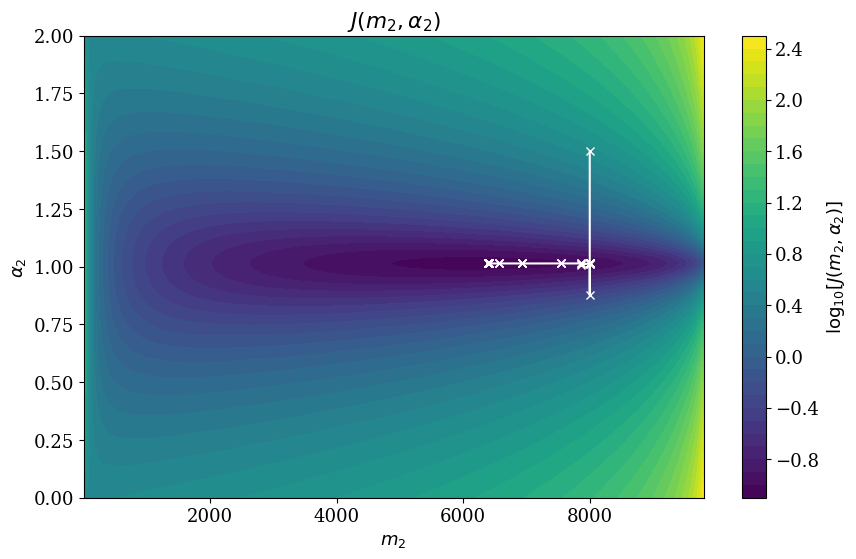

In [17]:
X, Y = np.meshgrid(m_vec, alpha2_vec)

fig, ax = plt.subplots(figsize=(10, 6))

cp = ax.contourf(X, Y, np.log10(mse_vals).T, levels=40)


ax.plot(history_m2, history_alpha2, "-x", c="white")
    
cbar = fig.colorbar(cp) 
cbar.ax.set_ylabel(r'$\log_{10}[J(m_{2},\alpha_{2})]$', rotation=90)
ax.set_title(r"$J(m_{2},\alpha_{2})$")
ax.set_xlabel(r'$m_{2}$')
ax.set_ylabel(r'$\alpha_{2}$')
plt.show()

In [20]:
index =  np.unravel_index(np.argmin(mse_vals), mse_vals.shape)
print("m2 = ", res["x"][0])
print("a2 =", res["x"][1])
print("m1 = ",  p - res["x"][0]*w2)
print("min MFMC = ", res["fun"])
print("MC = ", (1/p) * (delta1 - ((p-3)/(p-1))*sigma1**4))

m2 =  6384.534050074791
a2 = 1.0141431790228947
m1 =  36.15465949925209
min MFMC =  0.09146086471292847
MC =  3.772057509235353


In [21]:
opt_sigma2(k=k, m2=res["x"][0], s=s, m1=p - res["x"][0]*w2, sigma2=sigma2, delta2=delta2)

1.0141431842057902

In [21]:
p_vec = np.floor(np.linspace(int(1e2), int(5e4), 10))
mse__p = np.ones(len(p_vec))*np.inf

for kk in range(len(p_vec)):
    # get p value
    p = p_vec[kk]
    # get possible m-values
    x0 = [0.8*p/w2, 1.5]
    linear_constraint = LinearConstraint([[1, 0], [0, 1]], [2, 0], [p/w2 - 100, 20])
    # optimize
    res = minimize(MSE, x0,  method="trust-constr", constraints=linear_constraint)
    # get minimum
    mse__p[kk] = np.min(res["fun"])

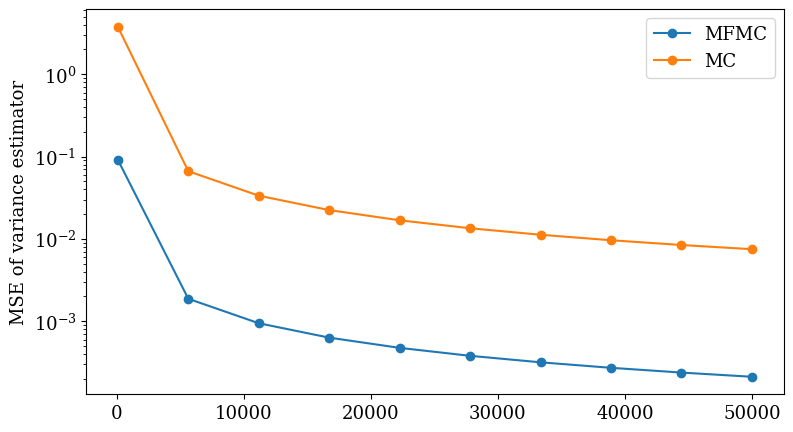

In [25]:
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(p_vec, mse__p, "-o", label="MFMC")
ax.plot(p_vec, (1/p_vec) * (delta1 - ((p_vec-3)/(p_vec-1))*sigma1**4),"-o",  label="MC")
ax.legend()
ax.set_ylabel("MSE of variance estimator")
ax.set_yscale("log")
#ax.set_xscale("log")